# UKF estimation of 3D parabolic motion from a single camera

Debido a que las cónicas son proyectivamente equivalentes podría pensarse que la imagen de la trayectoria de un movimiento parabólico en una sola cámara no permite reconstruir la trayectoria 3D.

Sin embargo, si la cámara está calibrada y las posiciones observadas tienen medidas de tiempo, podemos aprovechar las leyes del movimiento para construir un estimador probabilístico capaz de recuperar el estado de movimiento 3D con mucha precisión. El modelo de observación es no lineal, por lo que utilizaremos el [UKF](https://en.wikipedia.org/wiki/Kalman_filter#Unscented_Kalman_filter).

## Cámara calibrada

In [1]:
!pip install widgetsnbextension



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sys
if 'pyodide' in sys.modules:
    %pip install ipywidgets
    %pip install ipympl

%matplotlib widget

import cv2
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from umucv.kalman import kalman, ukf
import umucv.htrans as ht

from mpl_toolkits.mplot3d import Axes3D
from umucv.htrans import kgen, sepcam, jr, jc, col, row, htrans, lookat2, inhomog
from ipywidgets import interact, IntSlider

degree = np.pi/180

In [3]:
def clean(fig):
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False
    fig.canvas.capture_scroll = False

def fig3d(size=(6,5)):
    fig = plt.figure(figsize=size)
    plt.subplots_adjust(top=1)
    clean(fig)
    return fig, fig.add_subplot(111, projection='3d')

#def plot3(ax,c,col):
#    ax.plot(c[:,0],c[:,1],c[:,2],color=col)

In [4]:
def cameraOutline2(M, sc = 0.3):

    K,R,C = sepcam(M)

    # formamos una transformación 3D para mover la cámara en el origen a la posición de M
    rt = jr(jc(R, -R @ col(C)),
            row(0,0,0,1))

    x = 1;
    y = x;
    z = 0.99;

    ps =[x,    0,    z,
         (-x), 0,    z,
         0,    0,    z,
         0,    1.3*y,z,
         0,    (-y), z,
         x,    (-y), z,
         x,    y,    z,
         (-x), y,    z,
         (-x), (-y), z,
         x,    (-y), z,
         x,    y,    z,
         0,    y,    z,
         0,    0,    z,
         0,    0,    0,
         1,    1,    z,
         0,    0,    0,
         (-1), 1,    z,
         0,    0,    0,
         (-1), (-1), z,
         0,    0,    0,
         (1), (-1),  z,
         0,    0,    0,
         0,    0,    (2*x)]

    ps = np.array(ps).reshape(-1,3)
    return htrans(la.inv(rt), sc * ps)

In [ ]:
def mkCov2p(p1,p2,thick=0.2):
    d = np.array([p1,p2])
    m = np.mean(d,axis=0)
    c = np.cov(d,rowvar=False)
    c = c + np.eye(len(p1)) * la.norm(np.array(p1)-np.array(p2))*thick
    return m,c

u = np.linspace(0.0, 2.0 * np.pi, 20)
v = np.linspace(0.0, np.pi, 20)
x_0 = np.outer(np.cos(u), np.sin(v))
y_0 = np.outer(np.sin(u), np.sin(v))
z_0 = np.outer(np.ones_like(u), np.cos(v))

def ellip3d(mc):
    m,c = mc
    l,
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    =la.eigh(c)
    tran = np.diag(np.sqrt(abs(l))) @ r.T
    return (np.array([x_0.flatten(),y_0.flatten(),z_0.flatten()]).T @ tran + m).T.reshape(3,len(u),len(v))

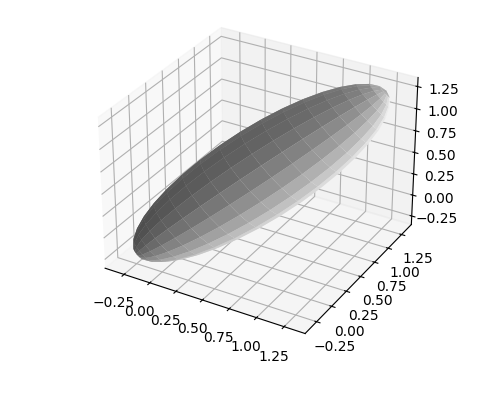

In [32]:
# check the uncertainty ellipsoid in 3D
if True:
    m,c = mkCov2p((0,0,0),(1,1,1),thick=0.1)
    _, ax = fig3d((5,4))
    ax.plot_surface( *ellip3d((m,c)), color='w');

Generamos una trayectoria sintética.

In [7]:
x0 = np.array([0,0,0])

angle1 = 20*degree
angle2 = 80*degree
v0 = 10*np.array([np.cos(angle1)*np.cos(angle2), np.sin(angle1)*np.cos(angle2), np.sin(angle2)])

a = np.array([0,0, - 9.8])
t = np.arange(0,2.01,1/25)

Zt = xt,yt,zt = ht.col(x0)  +  ht.col(v0)* ht.row(t) + 1/2 * ht.col(a) * ht.row(t**2)

Creamos una cámara sintética y mostramos la situación de la cámara y la trayectoria del objeto.

In [8]:
K = kgen((640,480),1.6)
P =  lookat2((6,6,2),(0,0,2))  # a 2 metros de altura, apuntando horizontalmente
M = K @ P

camline = cameraOutline2(M,0.5)

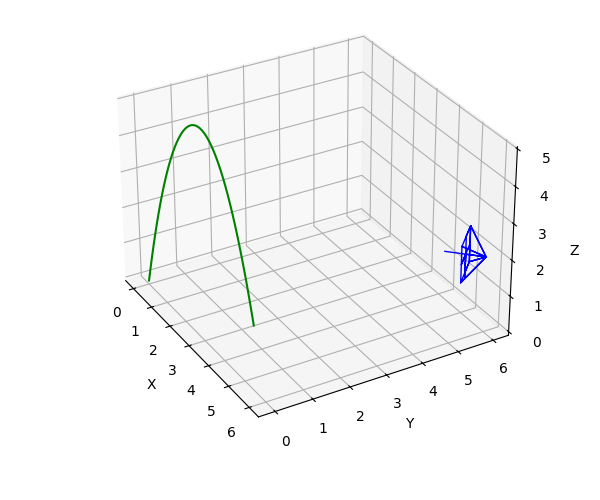

In [9]:
_, ax = fig3d()
ax.plot(*camline.T,'blue',lw=1)
ax.plot(*Zt,'green')
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.view_init(elev=30., azim=-30);

Las observaciones con las que vamos a trabajar son las imágenes del objeto contaminadas con ruido:

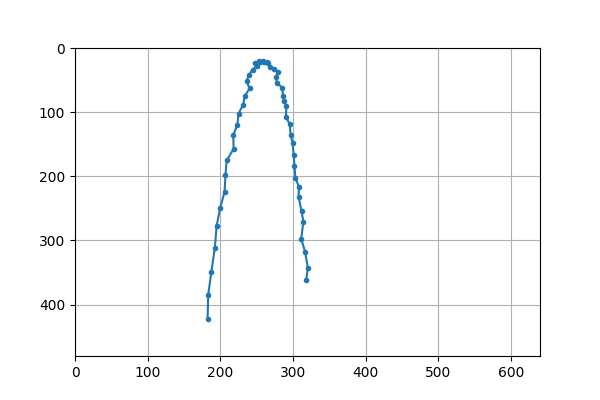

In [10]:
fig = plt.figure(figsize=(6,4))
clean(fig)
noise = 2
view = htrans(M,Zt.T) + noise*np.random.randn(len(t),2)
plt.plot(view[:,0],view[:,1],'.-');
plt.axis([0,640,480,0])
plt.grid()

Definimos la dinámica y el modelo de medida necesario para UKF. En este caso son directamente funciones en Python, aunque para la dinámica aprovechamos la estructura matricial. Para la observación se aplica la transformación proyectiva con la matriz de cámara, que suponemos conocida.

In [11]:
fps = 25
dt  = 1/fps

F = np.array(
    [1, 0, 0, dt,  0,  0,
     0, 1, 0,  0, dt,  0,
     0, 0, 1,  0,  0, dt,
     0, 0, 0,  1,  0,  0,
     0, 0, 0,  0,  1,  0,
     0, 0, 0,  0,  0,  1]).reshape(6,6)

B = np.array(
         [dt**2/2, 0,       0,
          0,       dt**2/2, 0,
          0,       0,       dt**2/2,
          dt,      0,       0,
          0,       dt,      0,
          0,       0,       dt]).reshape(6,3)


def f(x):
    return F@x + B@a

def h(x):
    return htrans(M,x[:3])

def b(x):
    return 0

Y hacemos una simulación de los primeros N frames, mostrando el elipsoide de incertidumbre de la posición en el último de ellos. (En este ejemplo no mostramos la predicción en el futuro).

In [12]:
mu = mu0 = np.array([0,0,0,0,0,0])

P = P0 = np.diag([1,1,1,10,10,10])**2


sigmaM = 0.001   # ruido del modelo
sigmaZ = noise   # pixel

Q = sigmaM**2 * np.eye(6)
R = sigmaZ**2 * np.eye(2)


# p.ej. prueba con 10, 35, 45. Cada vez se va acortando más el elipsoide de incertidumbre.
N = 60

res = [(mu,P,mu)]
res=[]

# mu es la estimación filtrada actualizada
for z in view[:N]:
    mu,P,pred = ukf(mu,P,f,Q,b,a,z,h,R)
    res += [(mu,P,pred)]

In [13]:
xe = [mu[0] for mu,_,_ in res] # coordenadas estimadas
ye = [mu[1] for mu,_,_ in res]
ze = [mu[2] for mu,_,_ in res]

mul,Pl,_ = res[-1]
ex,ey,ez = ellip3d((mul[:3],Pl[:3,:3]))

In [14]:
for mu,_,_ in res:
    print(mu)

[ 0.01746865 -0.024552    0.01322954  0.06000916 -0.08434222 -0.31934648]
[-0.05706335 -0.04553055  0.28266995 -1.82690411 -0.5672933   6.34911767]
[0.67905847 0.60186897 0.83943862 3.19256198 1.6727249  8.28354447]
[0.86078683 0.69522037 1.16468744 3.46858393 1.58102989 7.79329719]
[1.13155637 0.98758572 1.56325944 5.80905855 4.9263918  8.67943072]
[0.71621558 0.52863112 1.8057948  2.24632699 1.32936653 7.79345765]
[0.77538651 0.53591623 2.10770529 2.18953853 1.1697379  7.4156824 ]
[0.68337832 0.41086064 2.37326564 1.14848808 0.18268449 6.84008919]
[ 0.58598981  0.25044139  2.61445894  0.32100138 -0.76577335  6.25961483]
[ 0.62021497  0.23757757  2.86217857  0.46833728 -0.63463702  5.90605898]
[ 0.72804772  0.31129081  3.09546506  0.80804768 -0.25799696  5.55193148]
[1.12147536 0.69646311 3.26666322 1.55154766 0.58641838 4.98991704]
[1.09314267 0.62370326 3.47818477 1.42773038 0.45029785 4.67095733]
[1.31509082 0.82988117 3.62143917 1.67637515 0.75815854 4.17004907]
[1.48311245 0.9582

interactive(children=(IntSlider(value=10, description='k', max=61), Output()), _dom_classes=('widget-interact'…

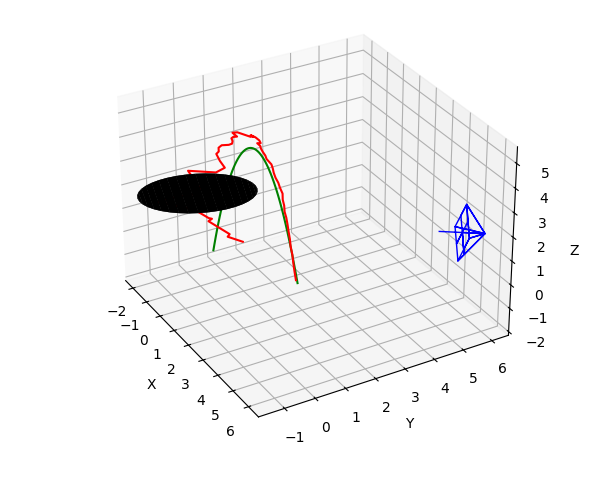

In [31]:
fig, ax = fig3d()
ax.plot(*camline.T,'blue',lw=1)
ax.plot(*Zt,'green')
ax.plot(xe,ye,ze,'red')
surf = ax.plot_surface(ex, ey, ez, color='black');
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.view_init(elev=30., azim=-30);
axs = plt.axis(); zls = ax.get_zlim3d()

def movepos(k):
    global surf
    mul,Pl,_ = res[k]
    ex,ey,ez = ellip3d((mul[:3],Pl[:3,:3]))
    surf.remove()
    surf = ax.plot_surface(ex, ey, ez, color='black');
    plt.axis(axs); ax.set_zlim3d(zls);
    fig.canvas.draw()

interact(movepos, k=IntSlider(min=0, max=len(res)-1, step=1, value=10));

En este experimento se asume una cámara completamente calibrada y situada de forma conocida. Esto puede no ser fácil de conseguir en aplicaciones prácticas.

## Estimación de orientación

Lo interesante sería estimar de la misma forma los ángulos de roll y tilt (o equivalentemente la dirección de la gravedad respecto al sistema de la cámara). Experimentos preliminares indican que el roll puede estimarse con robustez aceptable pero el tilt es más complicado.

### Roll

Trayectoria ground truth:

In [16]:
x0 = np.array([0,0,0])

angle1 = 20*degree
angle2 = 80*degree
v0 = 10*np.array([np.cos(angle1)*np.cos(angle2), np.sin(angle1)*np.cos(angle2), np.sin(angle2)])

a = np.array([0,0, - 9.8])

FPS=30

t = np.arange(0,2.01,1/FPS)

Zt = xt,yt,zt = ht.col(x0) + ht.col(v0)* ht.row(t) + 1/2 * ht.col(a) * ht.row(t**2)

Creamos una cámara sintética y mostramos la situación de la cámara y la trayectoria del objeto.

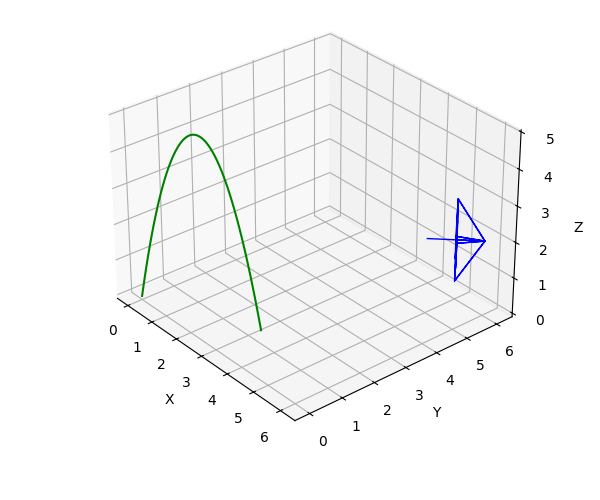

In [17]:
def R1(x):
    return ht.rotation((1,0,0),x)

def R2(x):
    return ht.rotation((0,1,0),x)

def R3(x):
    return ht.rotation((0,0,1),x)

GT_TILT = 0
GT_ROLL = 10

K = kgen((640,480),1.6)
P =  lookat2((6,6,2),(0,0,2))  # a 2 metros de altura, apuntando horizontalmente
M =  K @ R1(np.radians(GT_TILT)) @ R2(np.radians(0)) @ R3(np.radians(GT_ROLL)) @ P
Me = K @ P

camline = cameraOutline2(M,sc=0.7)

fig,ax = fig3d()
ax.plot(*camline.T,'blue',lw=1)
ax.plot(*Zt,'green')
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.view_init(elev=30., azim=-40)

Las observaciones con las que vamos a trabajar son las imágenes del objeto contaminadas con ruido:

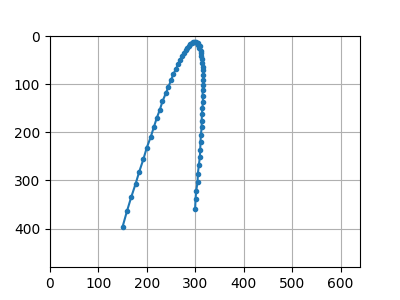

In [18]:
fig = plt.figure(figsize=(4,3))
clean(fig)
noise = 1/2
view = htrans(M,Zt.T) + noise*np.random.randn(len(t),2)
plt.plot(view[:,0],view[:,1],'.-');
plt.axis([0,640,480,0]); plt.grid();

Definimos la dinámica y el modelo de medida necesario para UKF. En este caso son directamente funciones en Python.

In [19]:
fps = FPS
dt  = 1/fps

F = np.array(
    [1, 0, 0, dt,  0,  0,
     0, 1, 0,  0, dt,  0,
     0, 0, 1,  0,  0, dt,
     0, 0, 0,  1,  0,  0,
     0, 0, 0,  0,  1,  0,
     0, 0, 0,  0,  0,  1]).reshape(6,6)

B = np.array(
         [dt**2/2, 0,       0,
          0,       dt**2/2, 0,
          0,       0,       dt**2/2,
          dt,      0,       0,
          0,       dt,      0,
          0,       0,       dt]).reshape(6,3)


def f(x):
    return np.hstack([F@x[:6] + B@a , x[6:]])



def h(x):
    C = K @ R1(0) @  R3(x[6])  @ la.inv(K) @ Me
    return htrans(C ,x[:3])

def b(x):
    return 0

Y hacemos una simulación de los primeros N frames, mostrando el elipsoide de incertidumbre de la posición en el último de ellos. (En este ejemplo no mostramos la predicción en el futuro).

interactive(children=(IntSlider(value=1, description='k', max=61), Output()), _dom_classes=('widget-interact',…

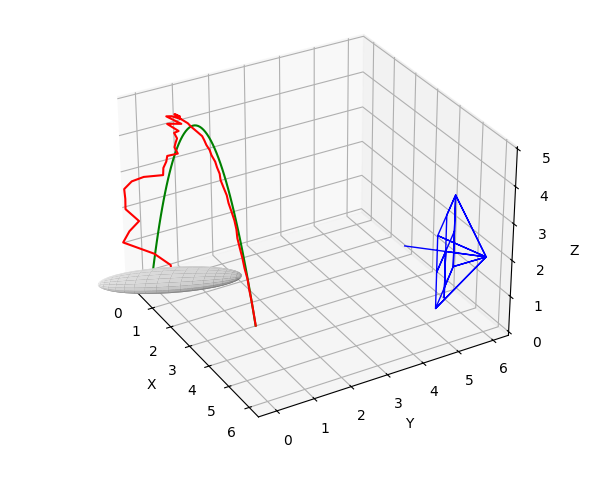

In [20]:
mu = np.array([0,1,0,0,0,0,0,0])
P  = np.diag([2,2,2,10,10,10,np.radians(10),np.radians(10)])**2

res = [(mu,P,None)]

sigmaM = 0.001   # ruido del modelo
sigmaZ = 1*noise   # pixel

Q = sigmaM**2 * np.eye(len(mu))
R = sigmaZ**2 * np.eye(2)

for z in view:
    mu,P,pred = ukf(mu,P,f,Q,b,a,z,h,R)
    res += [(mu,P,pred)]

xe = [mu[0] for mu,_,_ in res]
ye = [mu[1] for mu,_,_ in res]
ze = [mu[2] for mu,_,_ in res]



mul,Pl,_ = res[0]
ex,ey,ez = ellip3d((mul[:3],Pl[:3,:3]))

C = K @ R1(mul[7]) @  R3(mul[6])  @ la.inv(K) @ Me

finalcamline = cameraOutline2(C,sc=1)

fig2,ax2 = fig3d()
ax2.plot(*finalcamline.T,'blue',lw=1)
ax2.plot(*Zt,'green')
ax2.plot(xe,ye,ze,'red')
surf2 = ax2.plot_surface(ex, ey, ez, color='w');
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
ax2.axis([0,6,0,6,0,6])
ax2.view_init(elev=30., azim=-30)

def movepos_2(k):
    global surf2
    mul,Pl,_ = res[k]
    ex,ey,ez = ellip3d((mul[:3],Pl[:3,:3]))
    surf2.remove()
    surf2 = ax2.plot_surface(ex, ey, ez, color='w');

    plt.axis(axs); ax2.set_zlim3d(zls);
    fig2.canvas.draw()

interact(movepos_2, k=IntSlider(min=0, max=len(res)-1, step=1, value=1));

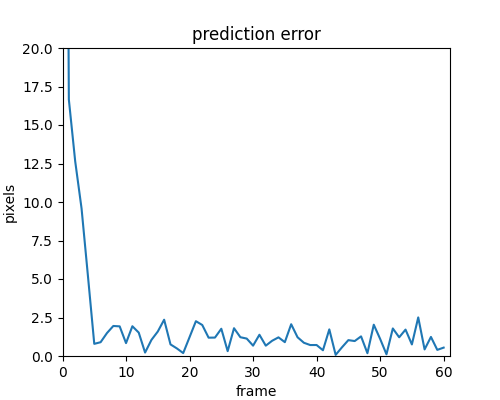

In [21]:
fig = plt.figure(figsize=(5,4))
clean(fig)
plt.plot(np.sum(abs(np.array([pred for _,_,pred in res[1:]]) - view),axis=1));
plt.axis([0,len(view),0,20]);
plt.title('prediction error');
plt.xlabel('frame'); plt.ylabel('pixels');

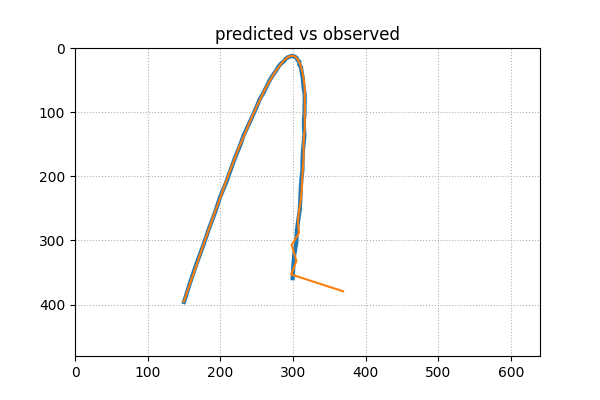

In [22]:
fig = plt.figure(figsize=(6,4))
clean(fig)
viewpred = np.array([pred for _,_,pred in res[1:]])
plt.plot(view[:,0],view[:,1],'-',lw=3)
plt.plot(viewpred[:,0],viewpred[:,1],'-');
plt.axis([0,640,480,0]); plt.grid(ls='dotted');
plt.title('predicted vs observed');

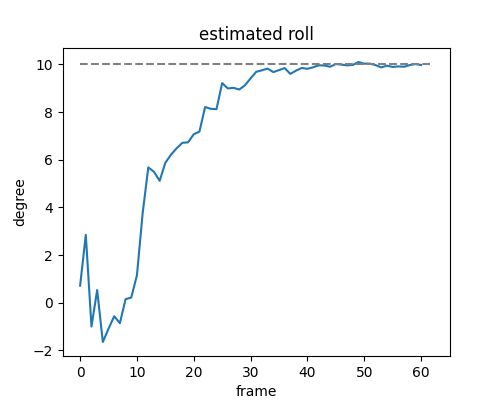

In [23]:
fig = plt.figure(figsize=(5,4))
clean(fig)
plt.plot(np.degrees([res[k][0][-2] for k in range(1,len(res))]));
plt.plot([0,len(res)],[GT_ROLL,GT_ROLL],ls='dashed',color='gray');
plt.title('estimated roll'); plt.xlabel('frame'); plt.ylabel('degree');

### Tilt

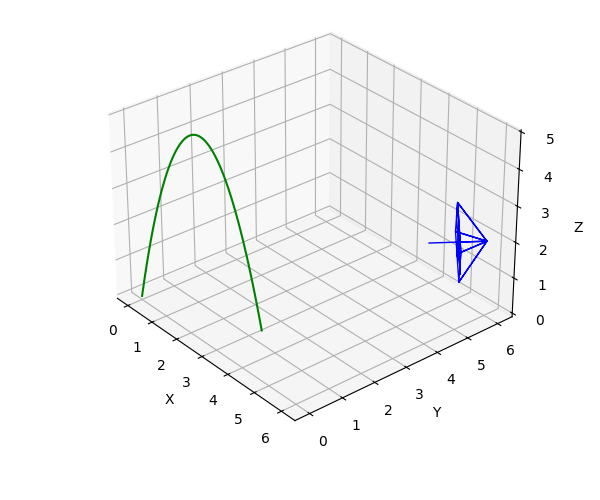

In [24]:
GT_TILT = 5
GT_ROLL = 0

K = kgen((640,480),1.6)
P =  lookat2((6,6,2),(0,0,2))  # a 2 metros de altura, apuntando horizontalmente
M =  K @ R1(np.radians(GT_TILT)) @ R2(np.radians(0)) @ R3(np.radians(GT_ROLL)) @ P
Me = K @ P

camline = cameraOutline2(M,sc=0.7)

fig,ax = fig3d()
ax.plot(*camline.T,'blue',lw=1)
ax.plot(*Zt,'green')
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.view_init(elev=30., azim=-40)

Observaciones:

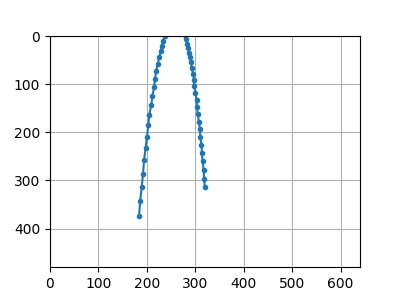

In [25]:
fig = plt.figure(figsize=(4,3))
clean(fig)
noise = 1/2
view = htrans(M,Zt.T) + noise*np.random.randn(len(t),2)
plt.plot(view[:,0],view[:,1],'.-');
plt.axis([0,640,480,0]); plt.grid();

Modelo de medida:

In [26]:
def h(x):
    C = K @ R1(x[7]) @  R3(0)  @ la.inv(K) @ Me
    return htrans(C ,x[:3])

Estimación:

interactive(children=(IntSlider(value=1, description='k', max=61), Output()), _dom_classes=('widget-interact',…

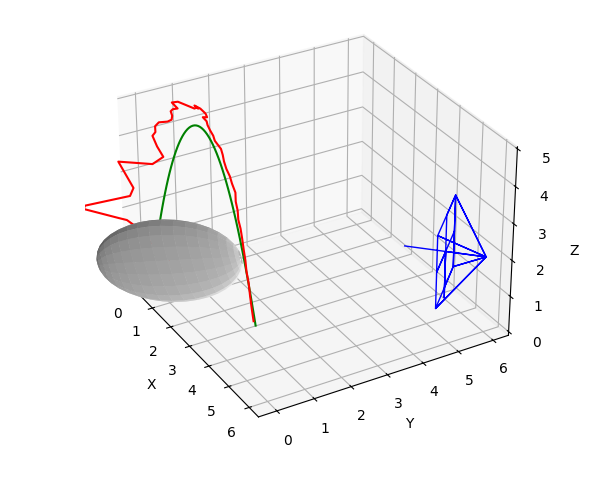

In [27]:
mu = np.array([0,1,0,0,0,0,0,0])
P  = np.diag([2,2,2,10,10,10,np.radians(10),np.radians(10)])**2

res = [(mu,P,None)]

sigmaM = 0.001   # ruido del modelo
sigmaZ = 1*noise   # pixel

Q = sigmaM**2 * np.eye(len(mu))
R = sigmaZ**2 * np.eye(2)

for z in view:
    mu,P,pred = ukf(mu,P,f,Q,b,a,z,h,R)
    res += [(mu,P,pred)]


xe = [mu[0] for mu,_,_ in res]
ye = [mu[1] for mu,_,_ in res]
ze = [mu[2] for mu,_,_ in res]



mul,Pl,_ = res[0]
ex,ey,ez = ellip3d((mul[:3],Pl[:3,:3]))

C = K @ R1(mul[7]) @  R3(mul[6])  @ la.inv(K) @ Me

finalcamline = cameraOutline2(C,sc=1)

fig3,ax3 = fig3d()
ax3.plot(*finalcamline.T,'blue',lw=1)
ax3.plot(*Zt,'green')
ax3.plot(xe,ye,ze,'red')
surf3 = ax3.plot_surface(ex, ey, ez, color='w');
ax3.set_xlabel('X'); ax3.set_ylabel('Y'); ax3.set_zlabel('Z')
ax3.axis([0,6,0,6,0,6])
ax3.view_init(elev=30., azim=-30)

def movepos_3(k):
    global surf3
    mul,Pl,_ = res[k]
    ex,ey,ez = ellip3d((mul[:3],Pl[:3,:3]))
    surf3.remove()
    surf3 = ax3.plot_surface(ex, ey, ez, color='w');
    plt.axis(axs); ax3.set_zlim3d(zls);
    fig3.canvas.draw()

interact(movepos_3, k=IntSlider(min=0, max=len(res)-1, step=1, value=1));

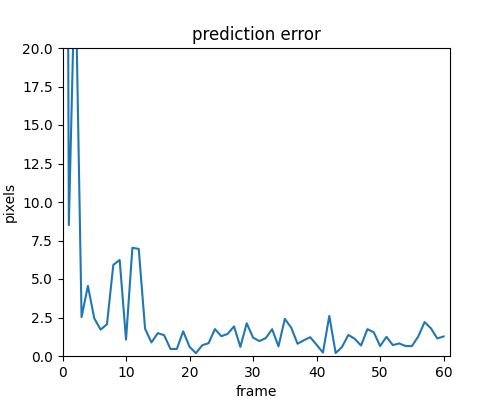

In [28]:
fig = plt.figure(figsize=(5,4))
clean(fig)
plt.plot(np.sum(abs(np.array([pred for _,_,pred in res[1:]]) - view),axis=1));
plt.axis([0,len(view),0,20]);
plt.title('prediction error');
plt.xlabel('frame'); plt.ylabel('pixels');

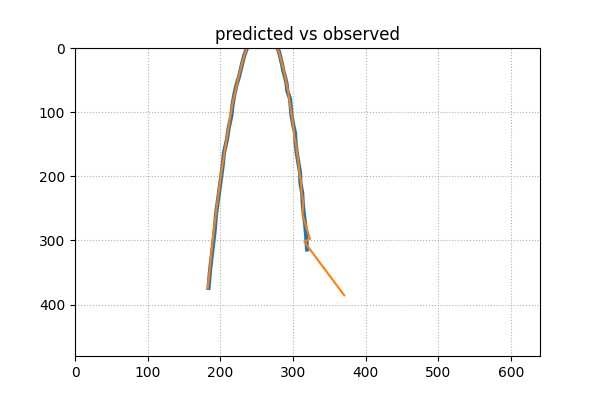

In [29]:
fig = plt.figure(figsize=(6,4))
clean(fig)
viewpred = np.array([pred for _,_,pred in res[1:]])
plt.plot(view[:,0],view[:,1],'-',lw=3)
plt.plot(viewpred[:,0],viewpred[:,1],'-');
plt.axis([0,640,480,0]); plt.grid(ls='dotted');
plt.title('predicted vs observed');

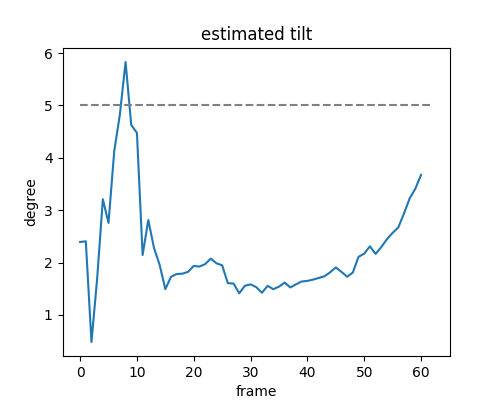

In [30]:
fig = plt.figure(figsize=(5,4))
clean(fig)
plt.plot(np.degrees([res[k][0][-1] for k in range(1,len(res))]));
plt.plot([0,len(res)],[GT_TILT,GT_TILT],ls='dashed',color='gray');
plt.title('estimated tilt'); plt.xlabel('frame'); plt.ylabel('degree');

El tilt es más complicado de detectar. Con tilt 10º y noise 0.1 se consigue buen error de predicción, aunque el tilt estimado se aproxima lentamente a 10. Algo parecido ocurre con tilt 5º y noise 1/2. Puede predecir aceptablemente bien aunque el ángulo no sea preciso. Esto significa que esa variable de estado es "menos observable".

Sin embargo el roll es más robusto, aguanta 10 grados con noise 1/2.